In [ ]:
import pandas as pd

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, Dense, Activation, Flatten, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import SGD
import urllib.request
from collections import defaultdict
from copy import deepcopy

In [ ]:
# Load Data
with urllib.request.urlopen("https://raw.githubusercontent.com/PhilipWeinmann/WS2021/main/STV/NLU_Data_train.txt") as f:
  train = f.read().decode('utf-8')

with urllib.request.urlopen("https://raw.githubusercontent.com/PhilipWeinmann/WS2021/main/STV/NLU_Data_test.txt") as f:
  test = f.read().decode('utf-8')

#### Convert txt to dataframe

In [ ]:
samples_train = train.split("\n")
X_train = []
y_train = []
for i in range(len(samples_train)):
  if len(samples_train[i].split("\t")) == 2:
    X_train.append(samples_train[i].split('\t')[1])
    y_train.append(samples_train[i].split('\t')[0])
  else:
    pass

samples_test = test.split("\n")
X_test = []
y_test = []
for i in range(len(samples_test)):
  if len(samples_test[i].split("\t")) == 2:
    X_test.append(samples_test[i].split('\t')[1])
    y_test.append(samples_test[i].split('\t')[0])
  else:
    pass
train_dict = defaultdict(list)
test_dict = defaultdict(list)

for i in range(len(y_train)):
  train_dict[y_train[i]].append(X_train[i])

for i in range(len(y_test)):
  test_dict[y_test[i]].append(X_test[i])

print(sorted(train_dict.keys()))
print(sorted(test_dict.keys()))
print(len(train_dict.keys()))
print(len(test_dict.keys()))

['AddToPlaylist', 'BookRestaurant', 'ComparePlaces', 'GetDirections', 'GetPlaceDetails', 'GetTrafficInformation', 'GetWeather', 'PlayMusic', 'RateBook', 'RequestRide', 'SearchCreativeWork', 'SearchPlace', 'SearchScreeningEvent', 'ShareCurrentLocation', 'ShareETA']
['AddToPlaylist', 'BookRestaurant', 'ComparePlaces', 'GetDirections', 'GetPlaceDetails', 'GetTrafficInformation', 'GetWeather', 'PlayMusic', 'RateBook', 'RequestRide', 'SearchCreativeWork', 'SearchPlace', 'SearchScreeningEvent', 'ShareCurrentLocation', 'ShareETA']
15
15


#### Create Train and Test Dataframe

In [ ]:
cols = deepcopy(list(train_dict.keys()))
cols.insert(0, 'sentence')

train_df = pd.DataFrame(columns=cols)
for i in range(len(y_train)):
  row_dict = {}
  row_dict['sentence'] = X_train[i]
  for j in range(len(list(train_dict.keys()))):
    if list(train_dict.keys())[j] != y_train[i]:
      row_dict[list(train_dict.keys())[j]] = 0
    else:
      row_dict[list(train_dict.keys())[j]] = 1
  train_df = train_df.append(row_dict, ignore_index=True)
  row_dict.clear()

In [ ]:
test_df = pd.DataFrame(columns=cols)
for i in range(len(y_test)):
  row_dict = {}
  row_dict['sentence'] = X_test[i]
  for j in range(len(list(test_dict.keys()))):
    if list(test_dict.keys())[j] != y_test[i]:
      row_dict[list(test_dict.keys())[j]] = 0
    else:
      row_dict[list(test_dict.keys())[j]] = 1
  test_df = test_df.append(row_dict, ignore_index=True)
  row_dict.clear()

In [ ]:
print(train_df)
print(test_df)

                                               sentence  ... ShareCurrentLocation
0                    book a Ukraine  pub serves mineiro  ...                    0
1     Create a theme station with Jim Creeggan recor...  ...                    0
2            Weather at Bystrzyca Valley Landscape Park  ...                    0
3              What will the weather be in Deer River ?  ...                    0
4     I want to book a pizza  restaurant  close to A...  ...                    0
...                                                 ...  ...                  ...
9995  What movie schedules are animated movies  clos...  ...                    0
9996  What's the best hotel between Soho Grand and P...  ...                    0
9997      book in Southern Shores for 8 at Ariston Cafe  ...                    0
9998         show me the movie times in Dipson Theatres  ...                    0
9999                                  Play song  Softly  ...                    0

[10000 rows x 1

#### Count how many Data per Label we got

In [ ]:
count_dict = defaultdict(int)
for i in train_df.columns:
  count_dict[i] = 0
  for j in train_df[str(i)]:
    if j == 1:
      count_dict[i] += 1

for k, v in count_dict.items():
  print(k,v)

sentence 0
BookRestaurant 1508
PlayMusic 1460
GetWeather 1487
SearchScreeningEvent 1322
SearchCreativeWork 1347
AddToPlaylist 1359
RateBook 1389
GetTrafficInformation 10
GetDirections 18
SearchPlace 20
GetPlaceDetails 35
RequestRide 11
ComparePlaces 11
ShareETA 15
ShareCurrentLocation 8


#### Seperate Data

In [ ]:
X_train = train_df["sentence"].fillna("fillna").values
y_train = train_df.loc[ : , train_df.columns != 'sentence'].values

In [ ]:
X_test = test_df["sentence"].fillna("fillna").values
y_test = test_df.loc[ : , test_df.columns != 'sentence'].values

In [ ]:
X_train.shape, y_train.shape

((10000,), (10000, 15))

In [ ]:
X_test.shape, y_test.shape

((5927,), (5927, 15))

## Preprocessing and converting data to arrays

In [ ]:
text = X_train

Tokenizer = Tokenizer()
Tokenizer.fit_on_texts(text) 
Tokenizer_vocab_size = len(Tokenizer.word_index) + 1
Tokenizer_vocab_size, X_train.shape, y_train.shape

(9476, (10000,), (10000, 15))

In [ ]:
X_val = X_test
y_val = y_test

X_train_encoded_words = Tokenizer.texts_to_sequences(X_train)
X_val_encoded_words = Tokenizer.texts_to_sequences(X_test)
X_train_encoded_padded_words = sequence.pad_sequences(X_train_encoded_words, maxlen = 50)
X_val_encoded_padded_words = sequence.pad_sequences(X_val_encoded_words, maxlen = 50)

X_train_encoded_padded_words = np.asarray(X_train_encoded_padded_words).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_val_encoded_padded_words =np.asarray(X_val_encoded_padded_words).astype('float32')
y_val = np.asarray(y_val).astype('float32')

X_train_encoded_padded_words.shape, X_val_encoded_padded_words.shape

((10000, 50), (5927, 50))

In [ ]:
X_val_encoded_padded_words, X_train_encoded_padded_words

(array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 4.600e+01, 1.210e+02,
         8.800e+01],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.016e+03, 7.870e+02,
         9.660e+02],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 3.200e+01, 6.000e+00,
         2.000e+01],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 3.060e+02, 3.000e+00,
         6.810e+02],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 3.973e+03,
         6.600e+01],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.730e+02, 2.100e+01,
         5.100e+01]], dtype=float32),
 array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 1.460e+02, 1.020e+02,
         3.702e+03],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.770e+03, 2.300e+01,
         3.705e+03],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 4.500e+02, 2.376e+03,
         1.170e+02],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 7.000e+00, 2.158e+03,
         2.280e+02],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 3.000e+00,

## Neural Network with LSTM 

In [119]:
model = Sequential()

model.add(Embedding(Tokenizer_vocab_size, 200)) 

model.add(LSTM(10))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(200, activation='relu'))
model.add(Dense(15, activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 200)         1895200   
                                                                 
 lstm_10 (LSTM)              (None, 10)                8440      
                                                                 
 dense_29 (Dense)            (None, 200)               2200      
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_30 (Dense)            (None, 200)               40200     
                                                                 
 dense_31 (Dense)            (None, 15)                3015      
                                                                 
Total params: 1,949,055
Trainable params: 1,949,055
N

In [120]:
Nadam = tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)



model.compile(loss='categorical_crossentropy', optimizer=Nadam, metrics=['accuracy'])


history  = model.fit(X_train_encoded_padded_words,y_train, epochs = 5, batch_size=32, verbose=1, validation_data=(X_val_encoded_padded_words, y_val))

Epoch 1/5
313/313 [==============================] - 35s 74ms/step - loss: 0.4619 - accuracy: 0.8566 - val_loss: 0.1416 - val_accuracy: 0.9590
Epoch 2/5
313/313 [==============================] - 16s 51ms/step - loss: 0.0828 - accuracy: 0.9767 - val_loss: 0.1444 - val_accuracy: 0.9625
Epoch 3/5
313/313 [==============================] - 15s 48ms/step - loss: 0.0431 - accuracy: 0.9869 - val_loss: 0.1476 - val_accuracy: 0.9641
Epoch 4/5
313/313 [==============================] - 15s 47ms/step - loss: 0.0286 - accuracy: 0.9904 - val_loss: 0.2029 - val_accuracy: 0.9592
Epoch 5/5
313/313 [==============================] - 16s 50ms/step - loss: 0.0261 - accuracy: 0.9913 - val_loss: 0.1767 - val_accuracy: 0.9624


## Plots & Evaluation

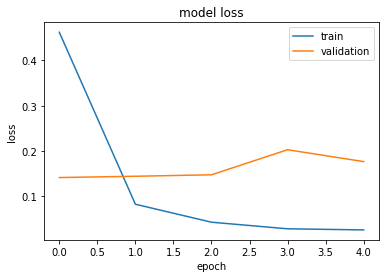

In [121]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

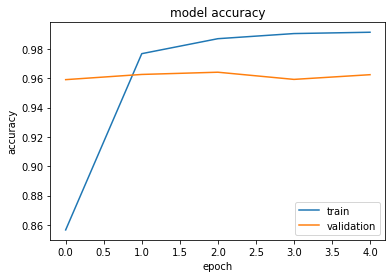

In [122]:
#accuracy
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [123]:
model.evaluate(X_val_encoded_padded_words, y_val)


186/186 [==============================] - 2s 9ms/step - loss: 0.1767 - accuracy: 0.9624


[0.17673182487487793, 0.9623755812644958]